In [1]:
from typing import override, Any

import numpy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

## 定义一个网络

这里搭建的是一个单层的全连接线性网络，相当于一个线性变换

这里用来训练一个线性分类器

In [2]:
class Net(nn.Module):
    @override
    def __init__(self, inFeature:int, outFeature:int) -> None:
        super().__init__()


        self.layer0 = nn.Linear(
                in_features=inFeature,
                out_features=outFeature,
                bias=True,
                device='cpu',
                dtype=torch.float32
            )
        return
    
    def forward(self, x):
        return self.layer0(x)
    
net = Net(2, 1)
print(net)

Net(
  (layer0): Linear(in_features=2, out_features=1, bias=True)
)


## 定义损失函数

In [3]:
def criterion(output:torch.Tensor, target:torch.Tensor,):
    return - (target * output).sum()/len(target)

## 生成数据集

继承`Dataset`类，实现我们自己的数据类型对应的数据集

In [4]:
class PointDataSet(Dataset):
    @override
    def __init__(self, pointCoords:torch.Tensor, pointValues:torch.Tensor) -> None:
        super().__init__()
        if len(pointCoords) != len(pointValues):
            raise IndexError(
                f'pointCoords\' length({len(pointCoords)}) not match pointValues\' length({len(pointValues)})'
                )
        self.pointCoords = pointCoords
        self.pointValues = pointValues
        return

    @override
    def __len__(self) -> int:
        return len(self.pointValues)

    @override
    def __getitem__(self, index) -> Any:
        return self.pointCoords[index], self.pointValues[index]

生成训练集

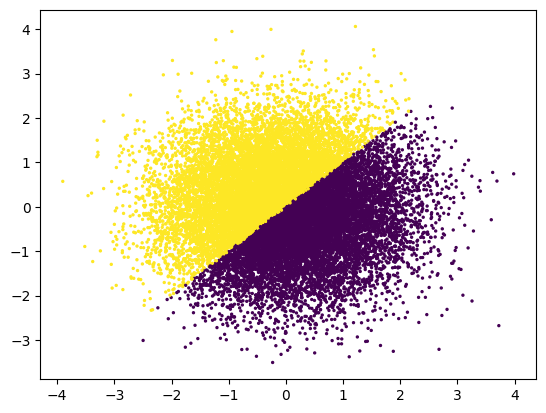

In [5]:
fn = lambda x1,x2: x2>x1

xDataTrain = torch.randn((20000, 2), dtype=torch.float32)
yDataTrain = torch.tensor([float(fn(i[0], i[1]))*2-1 for i in xDataTrain], dtype=torch.float32)

trainSet = PointDataSet(xDataTrain, yDataTrain)

plt.scatter(xDataTrain[:,0], xDataTrain[:,1], c=yDataTrain>0, s=2)
plt.show()

生成测试集

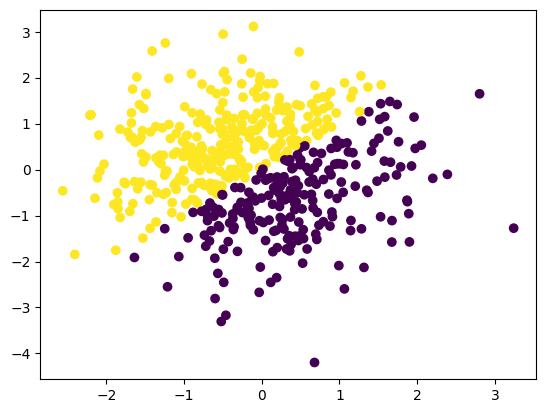

In [6]:
xDataValid = torch.randn((500, 2), dtype=torch.float32)
yDataValid = torch.tensor([float(fn(i[0], i[1]))*2-1 for i in xDataValid], dtype=torch.float32)

validSet = PointDataSet(xDataValid, yDataValid)

plt.scatter(xDataValid[:,0], xDataValid[:,1], c=yDataValid>0)
plt.show()

## 定义优化器

In [7]:
optimizer = optim.SGD(params=net.parameters(), lr=0.001, weight_decay=0.01)

## 开始训练

In [8]:
epoch = 5
net.zero_grad()
for _ in range(epoch):
    dataLoader = DataLoader(
        dataset=trainSet,
        batch_size=4,
        shuffle=True
    )
    for data in dataLoader:
        outData = net(data[0])
        loss = criterion(outData, data[1])
        # print(f'loss = {loss}')
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

## 训练结果测试

In [9]:
correctionCount = 0
for data in DataLoader(validSet, batch_size=1):
    if net(data[0])*data[1] > 0:
        correctionCount += 1

print(f'Correction: {correctionCount/xDataValid.shape[0] * 100:.2f}%')

Correction: 98.80%
